Useful links:
<br>
https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe/32011969
<br>
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
<br>
https://nlp.stanford.edu/projects/glove/

In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pydotplus as pyd

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/clean/cleaned_data.csv')
data['labels'] = data['labels'].apply(lambda x: ['negative', 'positive', 'neutral'].index(x))
data.head()

,tweets,labels
0,gas by my house hit going to chapel hill on sat,1
1,theo walcott is still watch rafa and johnny de...,0
2,its not that a gsp i just hate nick diaz wait ...,0
3,iranian general says iron dome deal with their...,0
4,mon amour obama tried to establish ties with t...,2


In [3]:
X_s = data['tweets'].values
y_s = data['labels'].values

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

In [7]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 1166, 1: 2919, 2: 3662}

In [8]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 292, 1: 721, 2: 924}

In [4]:
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1
print(vocab_size)

16673


In [18]:
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

In [19]:
max_length = 140
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [21]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [49]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [52]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        embedding_vector = [0]*200
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(16673, 200)

In [35]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [57]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(3, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 140)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 140, 200)          3334600   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 137, 50)           40050     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 68, 50)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 66, 100)           15100     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 33, 100)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3300)              0   

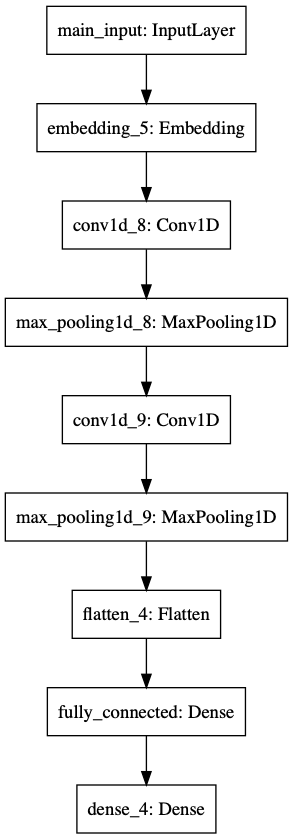

In [82]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_01.png')

In [58]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("models/sentiment_model.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [59]:
c = optimizers.Adam(lr = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(padded_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[checkpoint, earlystop, reduce_lr], 
               validation_split=0.2)

Train on 6197 samples, validate on 1550 samples
Epoch 1/50
6080/6197 [============================>.] - ETA: 0s - loss: 1.0179 - f1_m: 0.1578 - acc: 0.4734
Epoch 00001: val_f1_m improved from -inf to 0.20992, saving model to models/sentiment_model.h5
6197/6197 [==============================] - 5s 791us/sample - loss: 1.0162 - f1_m: 0.1595 - acc: 0.4749 - val_loss: 0.9835 - val_f1_m: 0.2099 - val_acc: 0.4961
Epoch 2/50
6080/6197 [============================>.] - ETA: 0s - loss: 0.9658 - f1_m: 0.3601 - acc: 0.5163
Epoch 00002: val_f1_m improved from 0.20992 to 0.37992, saving model to models/sentiment_model.h5
6197/6197 [==============================] - 4s 633us/sample - loss: 0.9663 - f1_m: 0.3599 - acc: 0.5156 - val_loss: 0.9500 - val_f1_m: 0.3799 - val_acc: 0.5090
Epoch 3/50
6144/6197 [============================>.] - ETA: 0s - loss: 0.9156 - f1_m: 0.4578 - acc: 0.5633
Epoch 00003: val_f1_m improved from 0.37992 to 0.43588, saving model to models/sentiment_model.h5
6197/6197 [====

Epoch 25/50
6144/6197 [============================>.] - ETA: 0s - loss: 0.1651 - f1_m: 0.9663 - acc: 0.9674
Epoch 00025: val_f1_m did not improve from 0.63980
6197/6197 [==============================] - 4s 631us/sample - loss: 0.1652 - f1_m: 0.9661 - acc: 0.9672 - val_loss: 1.0808 - val_f1_m: 0.6289 - val_acc: 0.6355
Epoch 00025: early stopping


In [60]:
score_1 = model_01.evaluate(padded_test, y_test)
score_1

1937/1937 [==============================] - 0s 158us/sample - loss: 1.0576 - f1_m: 0.6205 - acc: 0.6288


[1.0576424007570862, 0.62049514, 0.6288074]

[[ 99  76 117]
 [ 32 496 193]
 [ 55 246 623]]


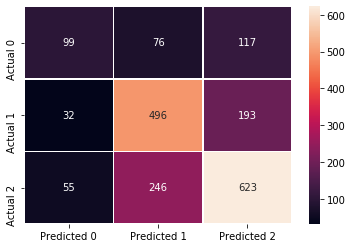

In [66]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'], 
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])

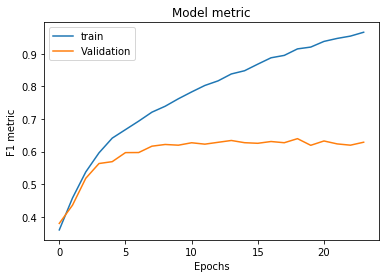

In [72]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

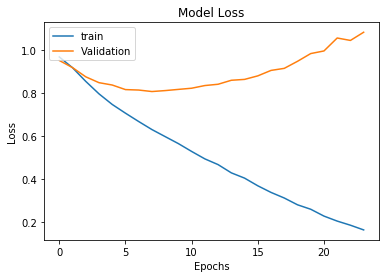

In [73]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()